In [31]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv("final_airbnb_dataset_xgboost.csv")

df.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'host_id',
 'host_url',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_x',
 'neighbourhood_cleansed_x',
 'neighbourhood_group_cleansed',
 'latitude_x',
 'longitude_x',
 'property_type_x',
 'room_type_x',
 'accommodates_x',
 'bathrooms_x',
 'bathrooms_text',
 'bedrooms_x',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30

In [33]:
# 1. Load and prepare your data
# features = [
#     'distance_score', 'price_score', 'number_of_reviews',
#     'availability_365', 'review_scores_rating',
#     'availability_30', 'availability_365', 'number_of_reviews'
# ]
features = [
    'distance_score', 'price_score', 'number_of_reviews',
    'availability_365', 'review_scores_rating',
]
df_model = df.dropna(subset=features + ['booked'])

X = df_model[features]
y = df_model['booked'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[0]	train-logloss:0.42523	eval-logloss:0.42430
[100]	train-logloss:0.00212	eval-logloss:0.00278


c:\Users\koola\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-logloss:0.00085	eval-logloss:0.00154
[300]	train-logloss:0.00063	eval-logloss:0.00140
[400]	train-logloss:0.00054	eval-logloss:0.00137
[500]	train-logloss:0.00048	eval-logloss:0.00132
[600]	train-logloss:0.00045	eval-logloss:0.00129
[676]	train-logloss:0.00042	eval-logloss:0.00131
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F1 Score: 0.9994


<Figure size 1000x600 with 0 Axes>

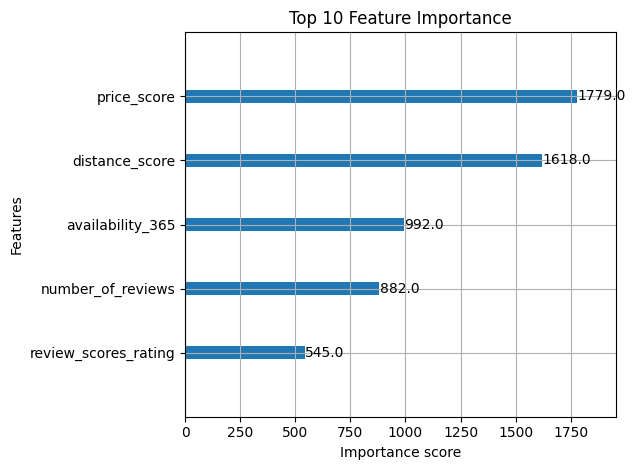


🔗 XGBoost: Top 10 Recommended Airbnbs with URLs:

ID: 6528060, Score: 1.0000, URL: 27808
ID: 753991, Score: 1.0000, URL: 30484
ID: 8731224, Score: 1.0000, URL: 34129
ID: 2362306, Score: 1.0000, URL: 13000
ID: 6494312, Score: 1.0000, URL: 27726
ID: 2641540, Score: 1.0000, URL: 13840
ID: 8951083, Score: 1.0000, URL: 34751
ID: 6837529, Score: 1.0000, URL: 28625
ID: 6747685, Score: 1.0000, URL: 28431
ID: 2314553, Score: 1.0000, URL: 12867


In [36]:
# 3. Set up XGBoost parameters
# For classification (if your labels are discrete classes)
params_clf = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class
    'eval_metric': 'logloss',        # or 'mlogloss' for multi-class
    'eta': 0.1,                      # learning rate
    'max_depth': 6,                  # tree depth
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 4. Choose which parameter set to use based on your problem
params = params_clf

# 5. Convert data to DMatrix format (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 6. Train the model with early stopping
num_rounds = 1000
evallist = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evallist,
    early_stopping_rounds=50,
    verbose_eval=100
)

# 7. Make predictions
y_pred = model.predict(dtest)

# For classification, convert probabilities to classes if needed

if params['objective'] == 'binary:logistic':
    y_pred_class = [1 if p >= 0.5 else 0 for p in y_pred]
else:  # multi-class
    y_pred_class = np.argmax(y_pred, axis=1)

# 8. Evaluate classification metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_class, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_class, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_class, average='weighted'):.4f}")


# 9. Feature importance analysis
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

# print out top 10 airbnb listings:
top_10_indices = np.argsort(y_pred)[-10:][::-1]
top_10_listings = df.iloc[top_10_indices]

print("\n🔗 XGBoost: Top 10 Recommended Airbnbs with URLs:\n")
for _, row in top_10_listings.iterrows():
    print(f"ID: {row['id']}, Score: {y_pred[row.name]:.4f}, URL: {row['listing_url']}")
    # print(f"ID: {row['id']}, Score:, {row['']}, URL: {row['listing_url']}")
# 10. Save the model
model.save_model('recommendation_xgboost_model.json')
